### Imports and config

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, r2_score

from sklearn import svm

%config InlineBackend.figure_format='retina'

### Read data

In [2]:
df = pd.read_csv('../dataset/data.csv')

### Constants

In [3]:
# Ethnicity labels
ETHNICITIES = { 
    0: 'White', 
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Other'
}

# Gender labels
GENDERS = { 
    0: 'Male', 
    1: 'Female'
}

REVERSE_GENDERS = {
    'Male' : 0,
    'Female' : 1
}

#Color channel
color_channel = 255

#Image size
img_size = 48

#Age range
age_min = 0
age_max = 50
age_range = age_max - age_min
age_bins = 10

#Train features
#Use
feature_to_use = 'pixels'
#To predict
feature_to_predict = 'age'

### Utils

In [4]:
def render_row(row):
    pixels = bytearray([int(px) for px in row['pixels'].split(' ')])
    img = Image.frombytes('L', (img_size, img_size), bytes(pixels))
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2, 2), dpi=100)
    axes.axis('off')
    imgplot = plt.imshow(img, cmap='gray')
    x_offset_text = 52
    plt.text(x_offset_text, 5, 'Age: ' + str(row['age']))
    plt.text(x_offset_text, 12, 'Ethnicity: ' + ETHNICITIES[row['ethnicity']])
    plt.text(x_offset_text, 19, 'Gender: ' + GENDERS[row['gender']])
    plt.show()
#render_row(df.loc[0])

In [5]:
def age_to_out(age, age_range=age_range):
    return age / age_range

In [6]:
def create_bins(lower_bound, width, quantity):
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width , width):
        bins.append((low, low+width))
    return bins

In [7]:
bins = pd.IntervalIndex.from_tuples(create_bins(age_min, age_bins, int(age_range / age_bins)))

In [8]:
#bins #to be used if approaching as classification problem

### Create balanced dataset

In [9]:
df['ethnicity'] = df['ethnicity'].map(ETHNICITIES)
df['gender'] = df['gender'].map(GENDERS)

In [10]:
#Ethnicity sample size
ethnicity_gender_sample_size = 480
age_filter = (df['age'] >= age_min) & (df['age'] <= age_max)

def ethnicity_gender_filter(df, i, j):
    return (df['ethnicity'] == ETHNICITIES[i]) & (df['gender'] == GENDERS[j])

def ethnicity_gender_age_filter(df, i, j, age_m, age_M):
    return ethnicity_gender_filter(df, i, j) & (df['age'] >= age_m) & (df['age'] <= age_M)

df_age_filter = df[age_filter][['age', 'ethnicity', 'gender', 'pixels']]

balanced_df = pd.concat([
    df_age_filter.loc[ethnicity_gender_filter(df_age_filter, i, j)]\
        .sample(ethnicity_gender_sample_size, random_state=19)
    for i in range(len(ETHNICITIES))
    for j in range(len(GENDERS))
])

In [11]:
def print_summary(dataset):
    n_bins = 10
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12, 3))
    axs[0].title.set_text('Age')
    axs[0].hist(dataset['age'], bins=n_bins)
    axs[1].title.set_text('Ethnicity')
    axs[1].hist(dataset['ethnicity'], bins=5*2-1)
    axs[2].title.set_text('Gender')
    axs[2].hist(dataset['gender'], bins=2*2-1)
    print(f'Number of records: {len(dataset)}')

Number of records: 4800


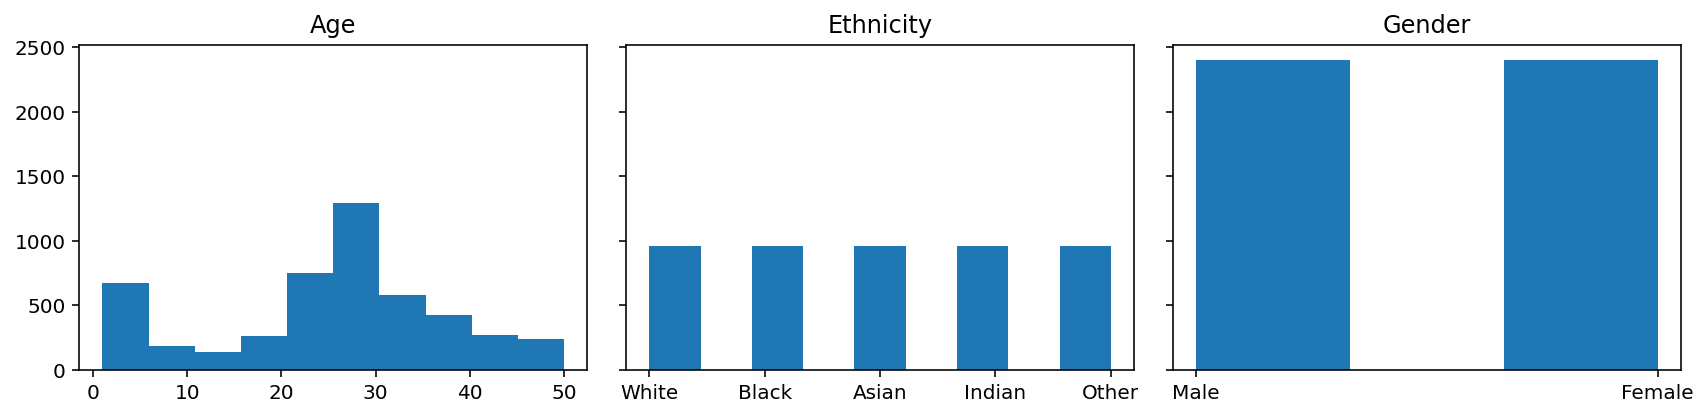

In [12]:
print_summary(balanced_df)

### Create Train - Test

In [13]:
balanced_df[feature_to_use] = balanced_df[feature_to_use]\
        .apply(lambda x: np.array(x.split(), dtype='float32'))

In [14]:
X = np.array(balanced_df[feature_to_use].tolist())
X = np.reshape(X, (-1, img_size, img_size, 1))
y = balanced_df[feature_to_predict].map(age_to_out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

## Custom AdalineSGD

### AdaSGD parameters

In [15]:
eta = 0.005
n_iter = 15
random_state = 19

### Model

In [16]:
from numpy.random import seed
class AdalineSGD(object):
    def __init__(self, value_range=age_range, eta=0.01, n_iter=20,
        shuffle=True, random_state=None):
        self.value_range = value_range
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
            
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        # Sigmoid
        return 1 / (1 + np.exp(-self.net_input(X)))
    
    def predict(self, X):
        return self.activation(X) #* self.value_range

### Data Preparation

In [17]:
X_ada_train = X_train.reshape(len(X_train), img_size * img_size, ) / color_channel
y_ada_train = y_train
X_ada_test = X_test.reshape(len(X_test), img_size * img_size, ) / color_channel
y_ada_test = y_test

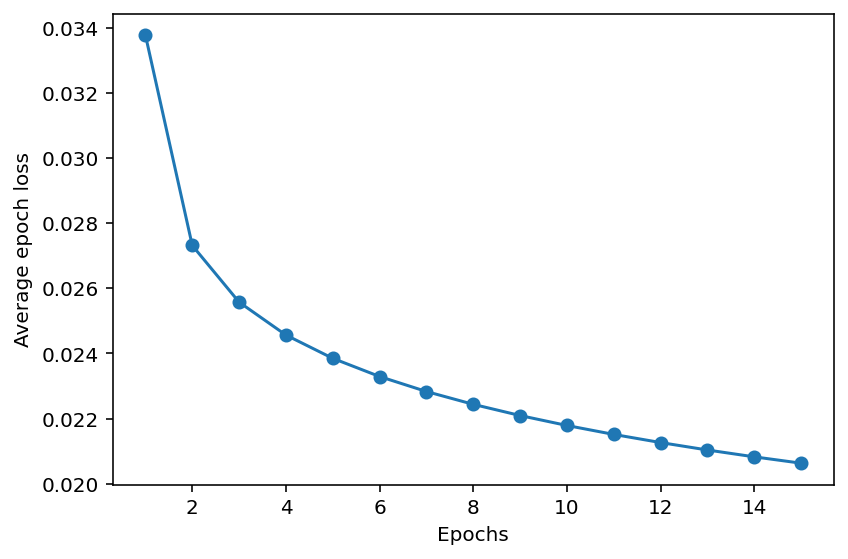

In [18]:
ada_sgd = AdalineSGD(eta=eta, n_iter=n_iter, shuffle=False, random_state=random_state)
ada_sgd.fit(X_ada_train, y_ada_train)
plt.plot(
    range(1, len(ada_sgd.cost_) + 1),
    ada_sgd.cost_, marker='o'
        )
plt.xlabel('Epochs')
plt.ylabel('Average epoch loss')
plt.tight_layout()
plt.show()

In [19]:
y_ada_pred = ada_sgd.predict(X_ada_test)

### Evaluate AdalineSGD

In [29]:
#asian
def evaluate_ethnicity(dataset, ethnicity, y_test, model, ada):
    y_test_e = dataset[feature_to_predict].loc[dataset['ethnicity'] == ethnicity].filter(items=y_test.index)
    y_test_e = y_test_e.map(age_to_out)
    X_test_e = dataset[feature_to_use].loc[dataset['ethnicity'] == ethnicity].filter(items=y_test.index).values
    X_test_e = np.array(X_test_e.tolist())
    X_test_e = np.reshape(X_test_e, (-1, img_size, img_size, 1))
    
    if ada:
        X_test_e = X_test_e.reshape(len(X_test_e), img_size * img_size, ) / color_channel
        
    y_tf_pred_e = np.rint(model.predict(X_test_e))
    score = r2_score(y_test_e, y_tf_pred_e)

def evaluate_all_ethnicities(dataset, y_test, model, ada):
    scores = [evaluate_ethnicity(dataset, e, y_test, model, ada) for e in ETHNICITIES.values()]
    return dict(zip(ETHNICITIES.values(), scores))

In [30]:
r2_score(y_ada_test, y_ada_pred)

0.06976742546101011

In [32]:
evaluate_all_ethnicities(balanced_df, y_ada_test, ada_sgd, True)

{'White': -1.6274055244761425,
 'Black': -5.035510599375875,
 'Asian': -1.410128959624017,
 'Indian': -2.2987492991177856,
 'Other': -1.9161032457460214}

## SVR model

In [33]:
svr = svm.SVR()
svr.fit(X_ada_train, y_ada_train)

SVR()

In [34]:
y_svr_pred = svr.predict(X_ada_test)

In [35]:
r2_score(y_ada_test, y_svr_pred)

0.5608075320422123

In [36]:
evaluate_all_ethnicities(balanced_df, y_ada_test, svr, True)

{'White': -1.149255751164374,
 'Black': -5.169684170881308,
 'Asian': -1.0404864971763823,
 'Indian': -2.3617987887798226,
 'Other': -1.2340143958450733}

## Create unbalanced dataset

In [37]:
#Size of majority group
majority_sample_size = 2000
#Size of minority group
minority_sample_size = int(majority_sample_size * .05)

white_male_df = df_age_filter.loc[ethnicity_gender_filter(df_age_filter, 0, 0)]\
        .sample(majority_sample_size, random_state=19)

white_female_df = df_age_filter.loc[ethnicity_gender_filter(df_age_filter, 0, 1)]\
        .sample(majority_sample_size, random_state=19)

unbalanced_df = pd.concat([
    df_age_filter.loc[ethnicity_gender_filter(df_age_filter, i, j)]\
        .sample(minority_sample_size, random_state=19)
    for i in range(1, len(ETHNICITIES))
    for j in range(len(GENDERS))
] + [white_female_df, white_male_df])

Number of records: 4800


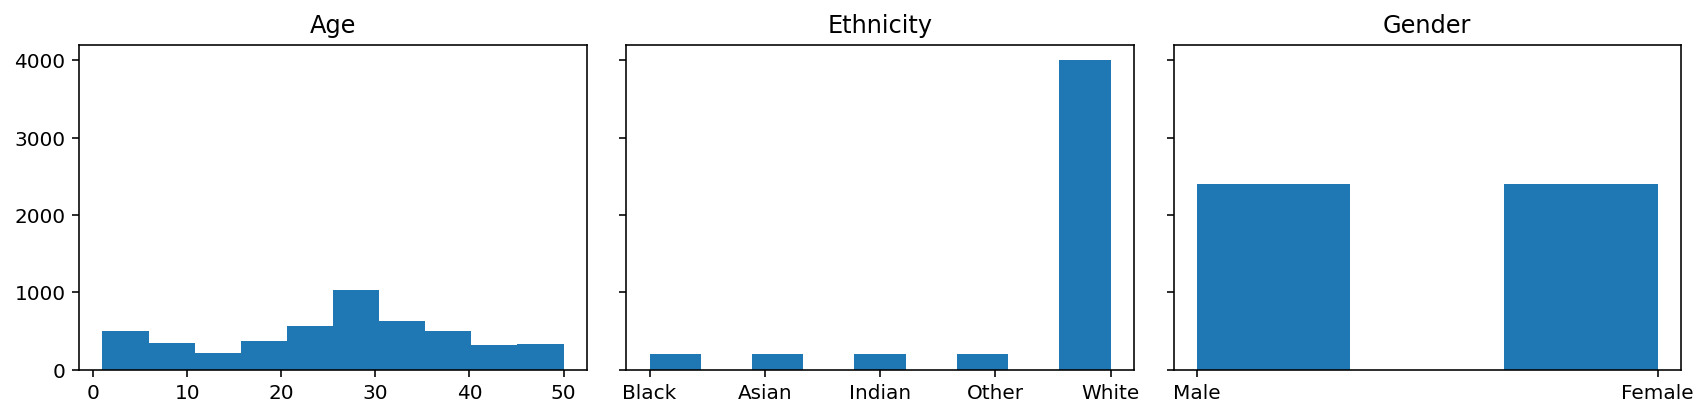

In [38]:
print_summary(unbalanced_df)

### Create Train - Test [Unbalanced]

In [39]:
unbalanced_df['pixels'] = unbalanced_df['pixels']\
        .apply(lambda x: np.array(x.split(), dtype='float32'))

X_unbalanced = np.array(unbalanced_df['pixels'].tolist())
X_unbalanced = np.reshape(X_unbalanced, (-1, img_size, img_size, 1))
y_unbalanced = unbalanced_df['gender'].map(REVERSE_GENDERS)
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(X_unbalanced, y_unbalanced, test_size=0.2, random_state=19)

## AdalineSGD Unbalanced

In [40]:
X_ada_train_unbalanced = X_train_unbalanced.reshape(len(X_train_unbalanced), img_size * img_size, ) / color_channel
y_ada_train_unbalanced = y_train_unbalanced
X_ada_test_unbalanced = X_test_unbalanced.reshape(len(X_test_unbalanced), img_size * img_size, ) / color_channel
y_ada_test_unbalanced = y_test_unbalanced

In [41]:
ada_sgd_unbalanced = AdalineSGD(eta=eta, n_iter=n_iter, shuffle=False, random_state=random_state)
ada_sgd_unbalanced.fit(X_ada_train_unbalanced, y_ada_train_unbalanced)

In [42]:
y_ada_pred_unbalanced = ada_sgd_unbalanced.predict(X_ada_test_unbalanced)

In [43]:
r2_score(y_ada_test_unbalanced, y_ada_pred_unbalanced)

0.4005656105089659

In [44]:
evaluate_all_ethnicities(unbalanced_df, y_test_unbalanced, ada_sgd_unbalanced, True)

{'White': -4.41512100310235,
 'Black': -12.918054338299736,
 'Asian': -5.0330763240338365,
 'Indian': -4.83912437399969,
 'Other': -9.479827382944972}